## Image classification AlexNet

***NOTE***

Be sure to use hardware acceleration to use the GPU. Click on `Runtime`, change `runtime type`, and select `GPU` for the *hardware accelerator* option.

* AlexNet, which employed an 8-layer CNN,
won the ImageNet Large Scale Visual Recognition Challenge 2012
by a large margin

* This network showed, for the first time,
that the features obtained by learning can transcend manually-designed features, breaking the previous paradigm in computer vision.

* The architectures of AlexNet and LeNet (see below) are somewhat similar

* There are also significant differences between AlexNet and LeNet.

* First, AlexNet is much deeper than the comparatively small LeNet5.
AlexNet consists of eight layers in the feature extractor,
two fully connected hidden layers, and one fully connected output layer.

* Second, AlexNet used the ReLU instead of the sigmoid
as its activation function.

* In AlexNet's first layer, the convolution window shape is $11\times11$.
Since the images in ImageNet are eight times higher and wider
than the MNIST images,
objects in ImageNet data tend to occupy more pixels with more visual detail.
Consequently, a larger convolution window is needed to capture the object.

* ReLU activation function makes model training easier when using different parameter initialization methods. This is because, when the output of the sigmoid activation function is very close to 0 or 1, the gradient of these regions is almost 0, so that backpropagation cannot continue to update some of the model parameters. In contrast, the gradient of the ReLU activation function in the positive interval is always 1 

* To augment the data even further, the training loop of AlexNet
added a great deal of image augmentation,
such as flipping, clipping, and color changes.

![From LeNet (left) to AlexNet (right).](http://d2l.ai/_images/alexnet.svg)

(left LeNet5, right AlexNet)

## Imports first

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import pandas as pd
%matplotlib inline

import tensorflow as tf
print(tf.__version__)

2.9.2


## Load the dataset

In [ ]:
# load data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## View the shape

In [ ]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28) (60000,)


In [ ]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28) (10000,)


## Find the unique numbers from the train labels

In [ ]:
classes = np.unique(Y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


## Plot some of the data

Text(0.5, 1.0, 'Ground Truth : 1')

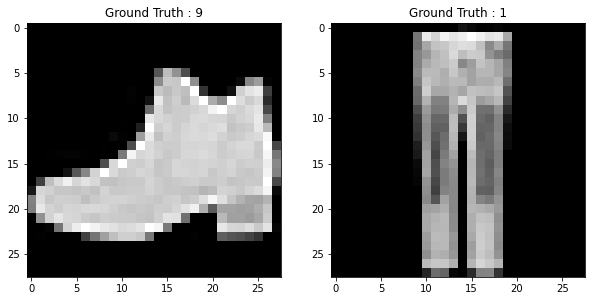

In [ ]:
data_point = 15

plt.figure(figsize=[10,5])
 
# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_train[data_point]))
 
# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[data_point,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(Y_test[data_point]))

## Reshape needed

Keras wants to know the depth of an image. 

For CNNS, Keras wants the format of the data as follows: [batches, width, height, depth]. 

In this case the colour channel/depth of the images is 1. Currently the shape is:

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train.shape

(60000, 28, 28)

But this doesn't have a depth value. So we can reshape it

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2], 1))

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train.shape

(60000, 28, 28, 1)

## View the shape

In [ ]:
print('Training data shape : ', X_train.shape, Y_train.shape)

Training data shape :  (60000, 28, 28, 1) (60000,)


In [ ]:
print('Testing data shape : ', X_test.shape, Y_test.shape)

Testing data shape :  (10000, 28, 28, 1) (10000,)


## Convert from categorical labels to one-hot encoded vectors

In this case there are 10 classes so we can tell the function to convert into a vector of length 10

In [ ]:
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
num_classes = 10

## Small twist!

API: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [ ]:
def resize_images(image, label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)

    image = tf.image.resize(image, (224,224))
    return image, label

In [ ]:
train_ds = (train_ds
                  .map(resize_images)
                  .shuffle(buffer_size=10000)
                  .batch(batch_size=64, drop_remainder=True))
test_ds = (test_ds
                  .map(resize_images)
                  .batch(batch_size=10, drop_remainder=False))

## Create a CNN model

In [ ]:
def baseline_model():
    # create model
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                                   activation='relu', input_shape=(224,224,1)))
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                                   activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                                   activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                                   activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(pool_size=3, strides=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
    return model

In [ ]:
model = baseline_model()

## Determine the number of trainable parameters

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       1

## Begin training

In [ ]:
model.fit(train_ds, epochs=2, batch_size=32, verbose=1)

Epoch 1/2
937/937 [==============================] - 81s 67ms/step - loss: 0.5242 - accuracy: 0.8105
Epoch 2/2
937/937 [==============================] - 65s 67ms/step - loss: 0.3500 - accuracy: 0.8739


## Predict on all the test data

In [ ]:
predictions = model.predict(test_ds)

1000/1000 [==============================] - 6s 6ms/step


In [ ]:
predictions.shape

(10000, 10)

In [ ]:
correct_values = np.argmax(Y_test,axis=-1)
predicted_classes = np.argmax(predictions,axis=-1)

In [ ]:
accuracy_score(predicted_classes,correct_values)*100

87.52

More efficient:

In [ ]:
targets = []
for x,y in test_ds.as_numpy_iterator():
  targets.extend(y)

In [ ]:
np.asarray(targets).shape

(10000, 10)

In [ ]:
accuracy_score(predicted_classes,np.argmax(targets,axis=-1))*100

87.52

## Tasks:

* Without removing any layers, reduce the number of trainable parameters. How does this compare in testing performance? Try this a few times to get the best performance you can.

* How did you decide on what to change?

* What would make this process faster? 

* How do you think this relates to implementing deep learning models in practice? What are some of the challenges?